In [34]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


### Data Loading, Preprocessing

In [35]:

df = pd.read_csv('updated_dataset (2).csv')

# 'Readmission_Flag' is the target variable
target = 'Readmission_Flag'

# date columns to datetime
date_columns = ['Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake', 'Date of readmission']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate additional parameters
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['TRACH_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Decannulation_Days_Difference'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days
df['Oral_Intake_Days_Difference'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days

# delta GCS
df['Delta_GCS'] = (df['DischargeGCS'] - df['GCS'])

# Binary prediction column: READMISSION
df['Readmission_Flag'] = df['Date of readmission'].notna().astype(int)

# Binary prediction column: MORTALITY
df['Mortality_Flag'] = df['Date of Death'].notna().astype(int)

# Drop original date columns 
df.drop(columns=['PEG ORDERS PLACED', 'PEG DATE', 'TRACH ORDERS PLACED', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake'], inplace=True)

#  relevant features
features = ['Age', 'Gender', 'Race', 'BMI', 'PEG', 'TRACH', 'PEG_Days_Difference', 'TRACH_Days_Difference',
             'Decannulation_Days_Difference', 'Oral_Intake_Days_Difference', 'Discharge Status Code', 'GCS', 
             'ISS', 'ICU LOS Days', 'Hospital LOS Days', 'Charlson_Comorbidity_Index',
               'DischargeGCS', 'VAP', 'NLR', 'Delta_GCS', 'Total_Neutrophils', 'Total_Lymphocytes'
               ]

X = df[features]

numeric_features = ['Age', 'BMI',  'PEG_Days_Difference', 'TRACH_Days_Difference',
                     'Decannulation_Days_Difference', 'Oral_Intake_Days_Difference', 
                       'GCS', 'ISS', 'ICU LOS Days', 'Hospital LOS Days', 'Charlson_Comorbidity_Index', 
                       'DischargeGCS', 'NLR', 'Delta_GCS', 'Total_Neutrophils', 'Total_Lymphocytes']
categorical_features = ['Gender', 'Race', 'VAP', 'PEG', 'TRACH']

# Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder())
        ]), categorical_features)
    ])

# Apply preprocessing
X = preprocessor.fit_transform(X)


# Save feature names
processed_feature_names = preprocessor.get_feature_names_out()
print(processed_feature_names)


y = df[target]


['num__Age' 'num__BMI' 'num__PEG_Days_Difference'
 'num__TRACH_Days_Difference' 'num__Decannulation_Days_Difference'
 'num__Oral_Intake_Days_Difference' 'num__GCS' 'num__ISS'
 'num__ICU LOS Days' 'num__Hospital LOS Days'
 'num__Charlson_Comorbidity_Index' 'num__DischargeGCS' 'num__NLR'
 'num__Delta_GCS' 'num__Total_Neutrophils' 'num__Total_Lymphocytes'
 'cat__Gender_F' 'cat__Gender_M' 'cat__Race_ASIAN' 'cat__Race_BLACK'
 'cat__Race_HISP/LATINO' 'cat__Race_OTHER' 'cat__Race_WHITE' 'cat__VAP_0'
 'cat__VAP_1' 'cat__PEG_0' 'cat__PEG_1' 'cat__TRACH_0' 'cat__TRACH_1']


In [36]:
df.columns

Index(['ID', 'Age', 'Gender', 'Race', 'BMI', 'Date of Admission',
       'Date of Hospital Discharge', 'PEG', 'TRACH', 'PEG TIME', 'TRACH TIME',
       'PEG SERVICE', 'TRACH SERVICE', 'Discharge Disposition',
       'Discharge Status Code', 'GCS', 'GCS Qualifier', 'ISS',
       '#CO-MORBIDITIES', 'ICU LOS Days', 'Hospital LOS Days',
       '#Of total complications', 'Date of Death', 'Date of readmission',
       'Comorbidities List', 'Charlson_Comorbidity_Index', 'DischargeGCS',
       'VAP', 'Total_Neutrophils', 'Total_Lymphocytes', 'NLR',
       'PEG_Days_Difference', 'TRACH_Days_Difference',
       'Decannulation_Days_Difference', 'Oral_Intake_Days_Difference',
       'PEG_ORDER_to_ADMISSION', 'Trach_ORDER_to_ADMISSION', 'Delta_GCS',
       'Readmission_Flag', 'Mortality_Flag'],
      dtype='object')

### Agglomerative/Hierarchical Clustering Model

Explained variance by 2 components: 0.28


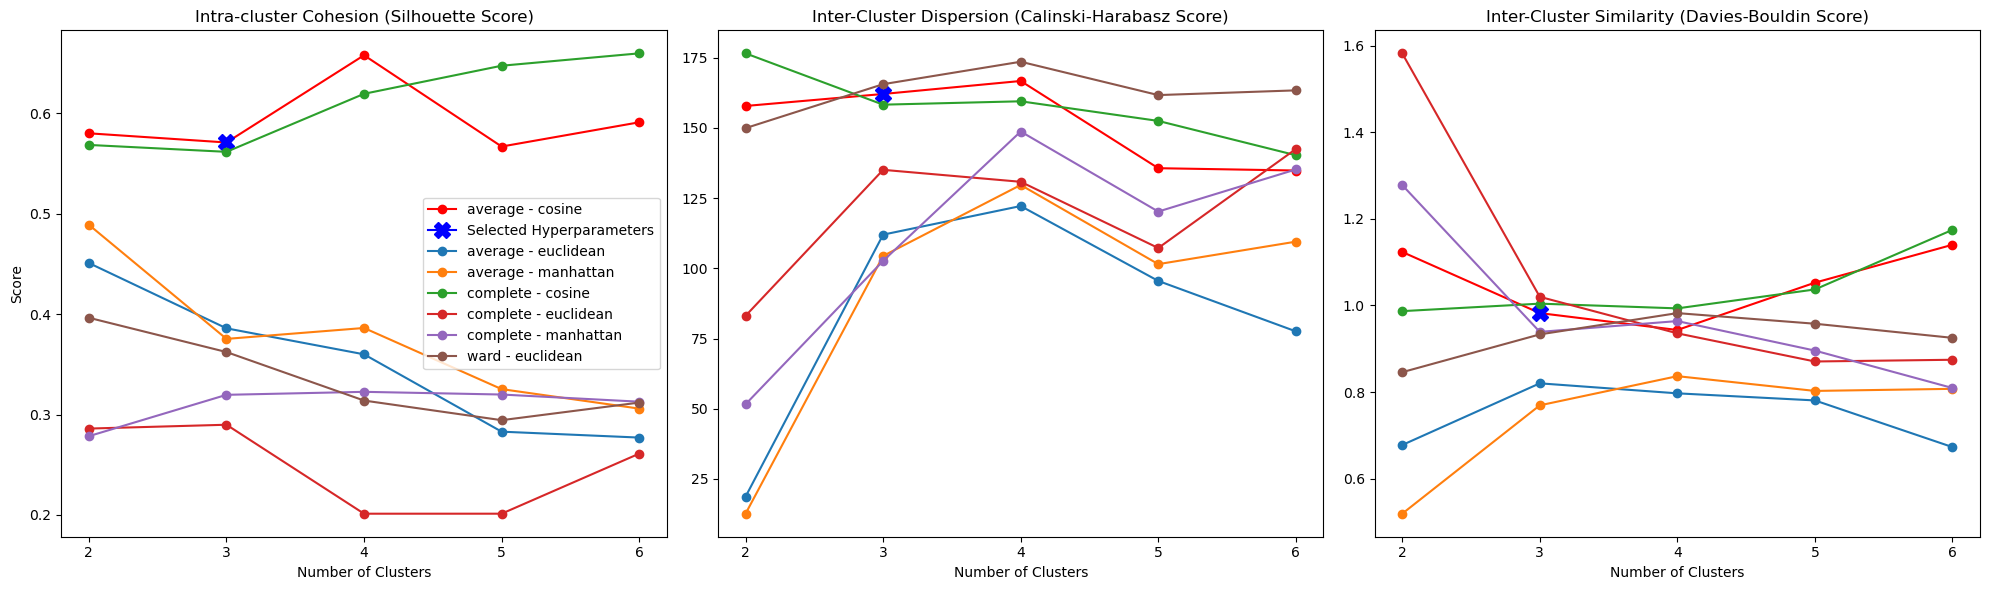

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns
import pandas as pd

n_clusters_range = [2, 3, 4, 5, 6]
linkage_methods = ['ward', 'complete', 'average']
metrics = ['euclidean', 'manhattan', 'cosine']

#  PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance by 2 components: {explained_variance:.2f}")

results = []

# Grid search
for n_clusters in n_clusters_range:
    for linkage in linkage_methods:
        for metric in metrics:
            if linkage == 'ward' and metric != 'euclidean':
                continue  

            clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=metric)
            cluster_labels = clustering.fit_predict(X_pca)

            silhouette_avg = silhouette_score(X_pca, cluster_labels, metric=metric)
            calinski_avg = calinski_harabasz_score(X_pca, cluster_labels)
            davies_bouldin_avg = davies_bouldin_score(X_pca, cluster_labels)

            results.append({
                'n_clusters': n_clusters,
                'linkage': linkage,
                'metric': metric,
                'silhouette_score': silhouette_avg,
                'calinski_harabasz_score': calinski_avg,
                'davies_bouldin_score': davies_bouldin_avg
            })

results_df = pd.DataFrame(results)


fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True)

#  Silhouette Score
for (linkage, metric), group in results_df.groupby(['linkage', 'metric']):
    if linkage == 'average' and metric == 'cosine':  
        axes[0].plot(group['n_clusters'], group['silhouette_score'], marker='o', color='red', label=f'{linkage} - {metric}')
        axes[0].plot(3, group[group['n_clusters'] == 3]['silhouette_score'], marker='X', color='blue', markersize=12, label='Selected Hyperparameters')
    else:
        axes[0].plot(group['n_clusters'], group['silhouette_score'], marker='o', label=f'{linkage} - {metric}')
axes[0].set_title('Intra-cluster Cohesion (Silhouette Score)')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Score')
axes[0].legend()
axes[0].set_xticks(n_clusters_range)

#  Calinski-Harabasz Score
for (linkage, metric), group in results_df.groupby(['linkage', 'metric']):
    if linkage == 'average' and metric == 'cosine':  
        axes[1].plot(group['n_clusters'], group['calinski_harabasz_score'], marker='o', color='red', label=f'{linkage} - {metric}')
        axes[1].plot(3, group[group['n_clusters'] == 3]['calinski_harabasz_score'], marker='X', color='blue', markersize=12, label='Chosen: 3 - Complete - Cosine')
    else:
        axes[1].plot(group['n_clusters'], group['calinski_harabasz_score'], marker='o', label=f'{linkage} - {metric}')
axes[1].set_title('Inter-Cluster Dispersion (Calinski-Harabasz Score)')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_xticks(n_clusters_range)

#  Davies-Bouldin Index
for (linkage, metric), group in results_df.groupby(['linkage', 'metric']):
    if linkage == 'average' and metric == 'cosine':  
        axes[2].plot(group['n_clusters'], group['davies_bouldin_score'], marker='o', color='red', label=f'{linkage} - {metric}')
        axes[2].plot(3, group[group['n_clusters'] == 3]['davies_bouldin_score'], marker='X', color='blue', markersize=12, label='Chosen: 3 - Complete - Cosine')
    else:
        axes[2].plot(group['n_clusters'], group['davies_bouldin_score'], marker='o', label=f'{linkage} - {metric}')
axes[2].set_title('Inter-Cluster Similarity (Davies-Bouldin Score)')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_xticks(n_clusters_range)

plt.tight_layout()
plt.show()


Optimal PCA Components: 2
Optimal Number of Clusters: 3
Optimal Linkage Method: average
Optimal Distance Metric: cosine
Silhouette Score: 0.5708650798867815
Davies-Bouldin Index (DBI): 0.9823827678655004
Calinski-Harabasz Index (CHI): 162.08441942137608


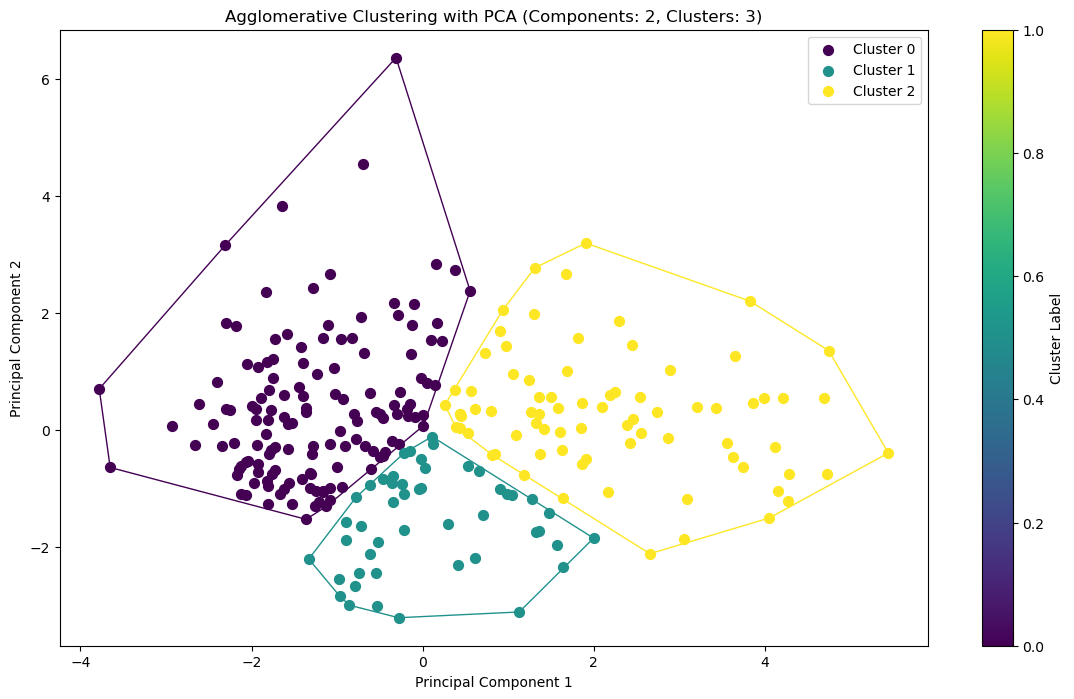

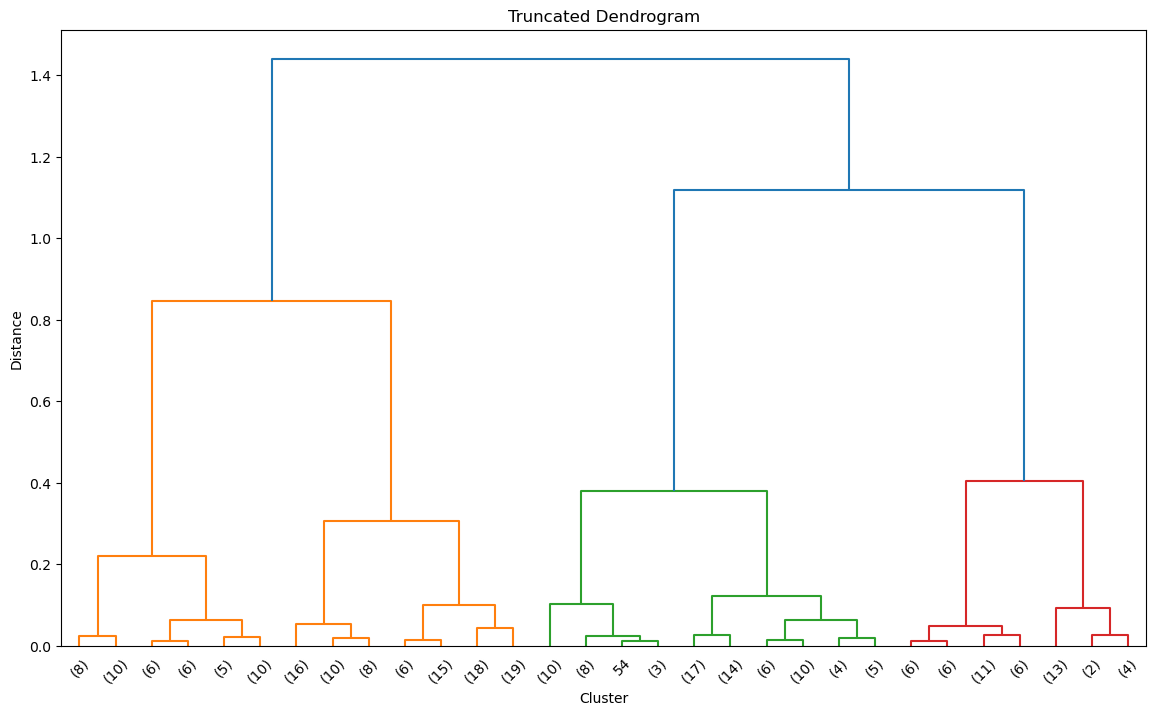

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
import pandas as pd
from scipy.spatial import ConvexHull
from matplotlib.colors import ListedColormap

# parameters
optimal_pca_components = 2
optimal_clusters = 3
optimal_linkage = 'average'
optimal_distance = 'cosine'

#  PCA
pca = PCA(n_components=optimal_pca_components, random_state=42)
X_pca = pca.fit_transform(X)

#  Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters=optimal_clusters, linkage=optimal_linkage, metric=optimal_distance)
cluster_labels_Agglomerative = clustering.fit_predict(X_pca)

#  silhouette score
silhouette_avg = silhouette_score(X_pca, cluster_labels_Agglomerative, metric=optimal_distance)


# Davies-Bouldin Index (DBI)
dbi = davies_bouldin_score(X_pca, cluster_labels_Agglomerative)

# Calinski-Harabasz Index (CHI)
chi = calinski_harabasz_score(X_pca, cluster_labels_Agglomerative)


print(f"Optimal PCA Components: {optimal_pca_components}")
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Optimal Linkage Method: {optimal_linkage}")
print(f"Optimal Distance Metric: {optimal_distance}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index (DBI): {dbi}")
print(f"Calinski-Harabasz Index (CHI): {chi}")

plt.figure(figsize=(14, 8))

cmap = plt.get_cmap('viridis', optimal_clusters)

for i in range(optimal_clusters):
    points = X_pca[cluster_labels_Agglomerative == i]
    plt.scatter(points[:, 0], points[:, 1], s=50, color=cmap(i), label=f'Cluster {i}')
    
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], color=cmap(i), lw=1)

plt.title(f'Agglomerative Clustering with PCA (Components: {optimal_pca_components}, Clusters: {optimal_clusters})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.show()

import scipy.cluster.hierarchy as sch

# hierarchical/agglomerative clustering through linkage
Z = linkage(X_pca, method=optimal_linkage, metric=optimal_distance)

# truncated dendrogram
plt.figure(figsize=(14, 8))
dendrogram = sch.dendrogram(Z, truncate_mode='lastp', p=30)  # Adjust p as needed
plt.title('Truncated Dendrogram')
plt.xlabel('Cluster')
plt.ylabel('Distance')

plt.show()


### Clustering Model Evaluation and Analysis

In [39]:
feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
X_df = pd.DataFrame(X, columns=feature_names)


In [40]:
from scipy.stats import ttest_ind

df['Cluster_Labels_Agglomerative'] = cluster_labels_Agglomerative


# distribution of the target variable across clusters
for i in range(optimal_clusters):
    cluster_group = df[df['Cluster_Labels_Agglomerative'] == i][target]
    rest_of_data = df[df['Cluster_Labels_Agglomerative'] != i][target]
    t_stat, p_val = ttest_ind(cluster_group, rest_of_data, equal_var=False)
    print(f"Cluster {i} vs Rest: t-statistic = {t_stat}, p-value = {p_val}")



Cluster 0 vs Rest: t-statistic = 0.034001523540398634, p-value = 0.9729021064646033
Cluster 1 vs Rest: t-statistic = 2.038022942878651, p-value = 0.045405687347507856
Cluster 2 vs Rest: t-statistic = -1.812148640861235, p-value = 0.07195297345917619


#### Mutual Information

In [41]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer

# Imputation
numeric_imputer = SimpleImputer(strategy='mean')
df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
X_processed = preprocessor.fit_transform(df[features])

# PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)


discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
df_discretized = df.copy()
df_discretized[numeric_features] = discretizer.fit_transform(df[numeric_features])

#  Mutual Information after discretization
mi_scores = {feature: mutual_info_score(df_discretized['Cluster_Labels_Agglomerative'], df_discretized[feature]) for feature in features}

mi_df = pd.DataFrame(list(mi_scores.items()), columns=['Feature', 'Mutual Information'])
print(mi_df)


                          Feature  Mutual Information
0                             Age            0.224671
1                          Gender            0.003650
2                            Race            0.020930
3                             BMI            0.028292
4                             PEG            0.003102
5                           TRACH            0.099859
6             PEG_Days_Difference            0.011121
7           TRACH_Days_Difference            0.007111
8   Decannulation_Days_Difference            0.017693
9     Oral_Intake_Days_Difference            0.007500
10          Discharge Status Code            0.084479
11                            GCS            0.232392
12                            ISS            0.143961
13                   ICU LOS Days            0.024464
14              Hospital LOS Days            0.034165
15     Charlson_Comorbidity_Index            0.221408
16                   DischargeGCS            0.061874
17                          

c:\Users\shrin\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


#### Cluster Sizes

In [42]:
cluster_counts = df['Cluster_Labels_Agglomerative'].value_counts()
print(cluster_counts)


Cluster_Labels_Agglomerative
0    137
2     78
1     48
Name: count, dtype: int64


#### Cluster Stratification, Descriptive Statistics, Service Categorization

  PEG_SERVICE_CATEGORY TRACH_SERVICE_CATEGORY
0         ACS & TRAUMA           ACS & TRAUMA
1                   NA                  Other
2                Other                  Other
3         ACS & TRAUMA           ACS & TRAUMA
4                Other                     NA
Summary Statistics for Each Cluster:
                                Age                                          \
                              count       mean        std   min   25%   50%   
Cluster_Labels_Agglomerative                                                  
0                             137.0  34.175182  13.588435  17.0  23.0  31.0   
1                              48.0  42.937500  18.660923  17.0  24.5  43.5   
2                              78.0  61.692308  15.012815  20.0  54.0  61.0   

                                             BMI             ...  \
                                75%   max  count       mean  ...   
Cluster_Labels_Agglomerative                                 ...   
0       

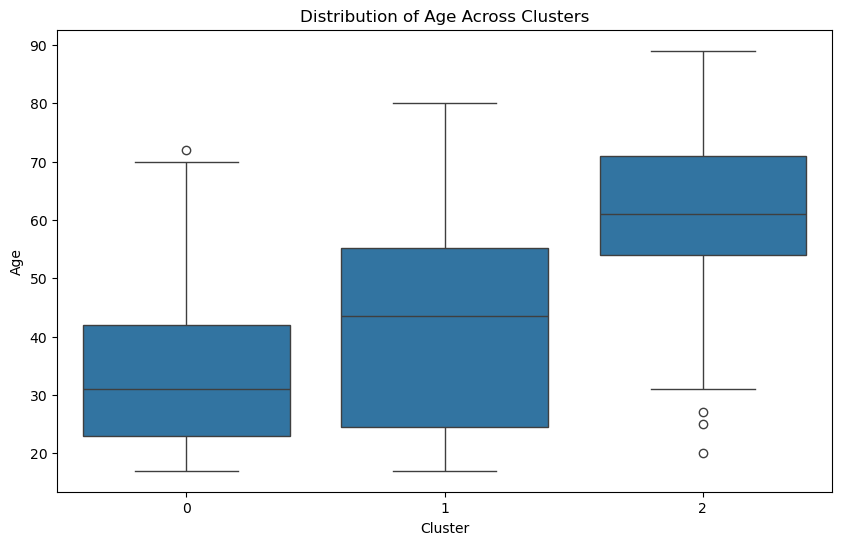

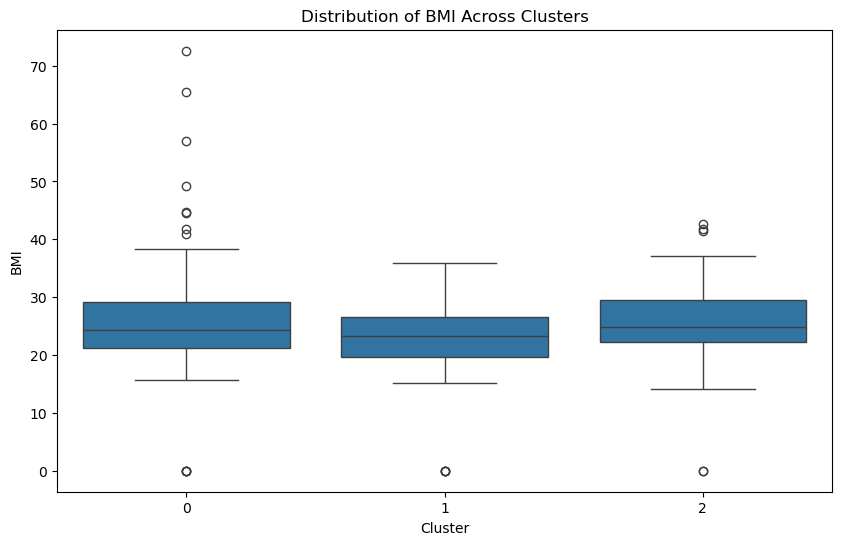

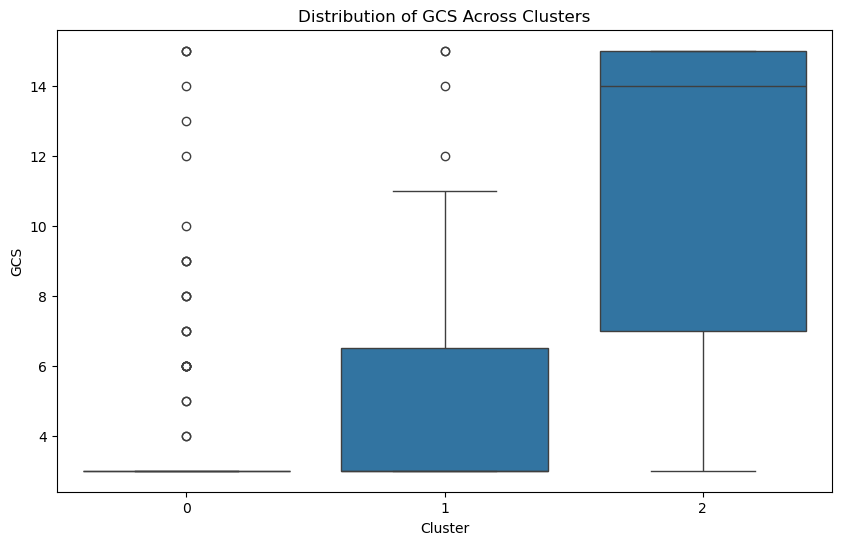

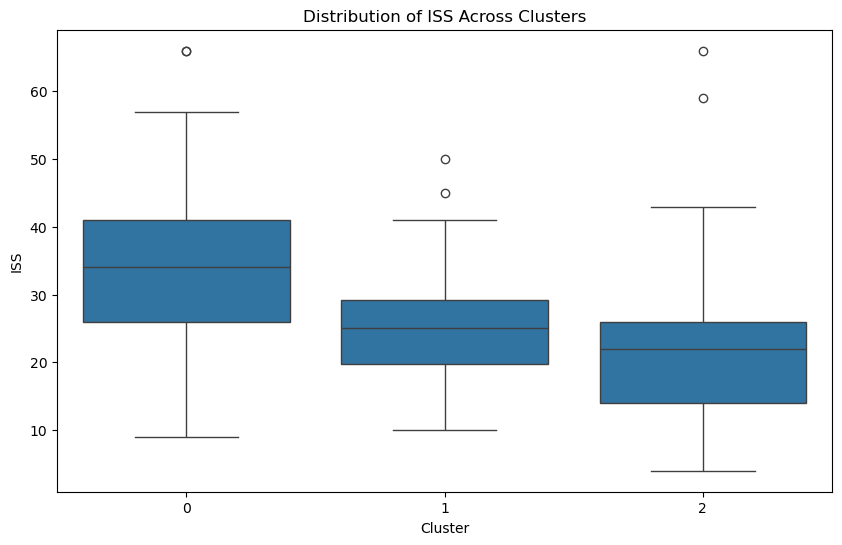

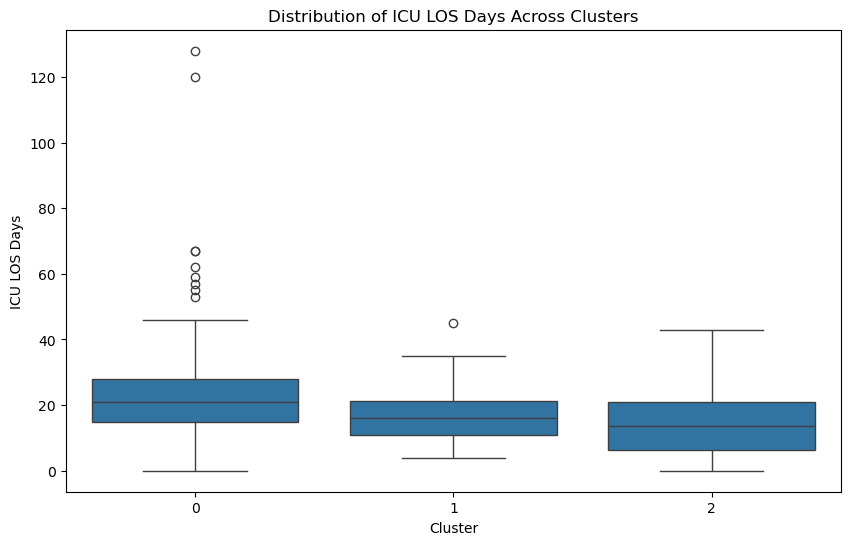

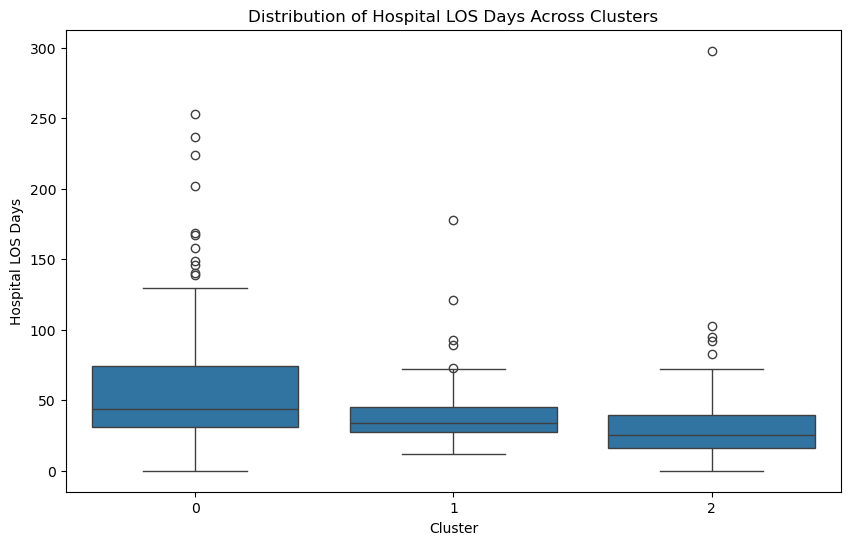

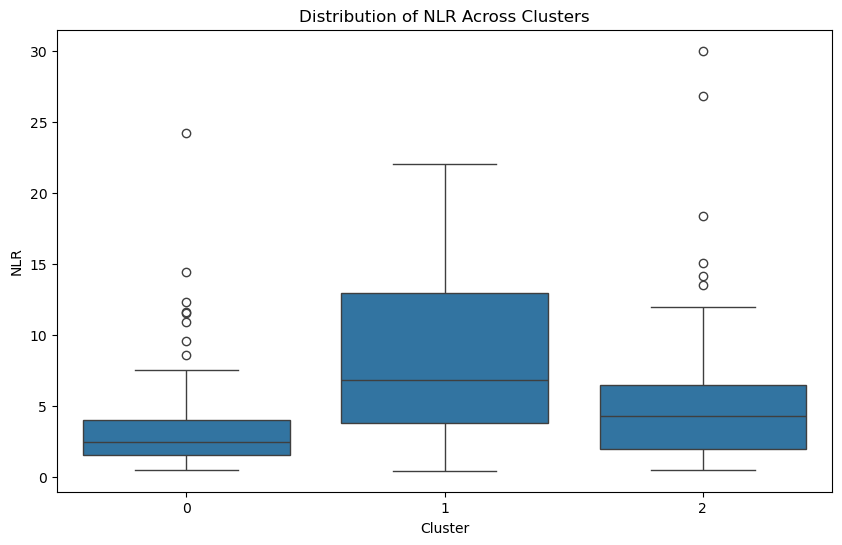

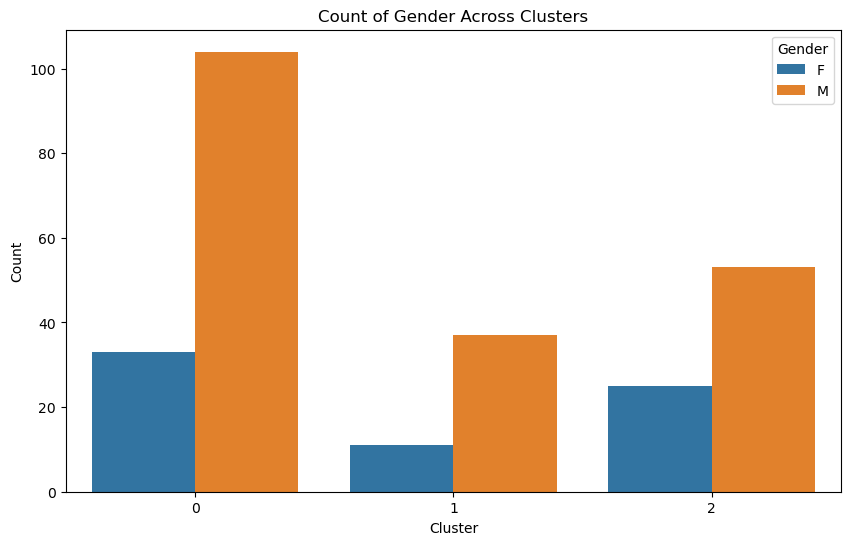

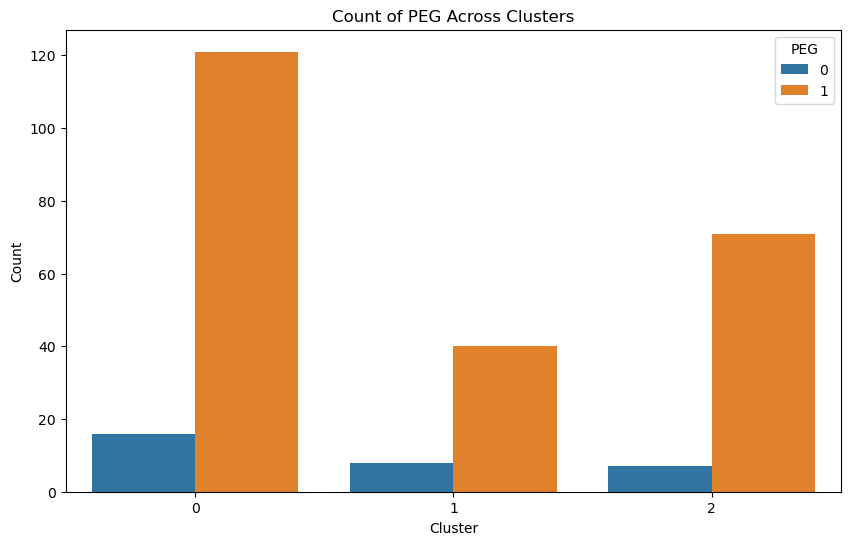

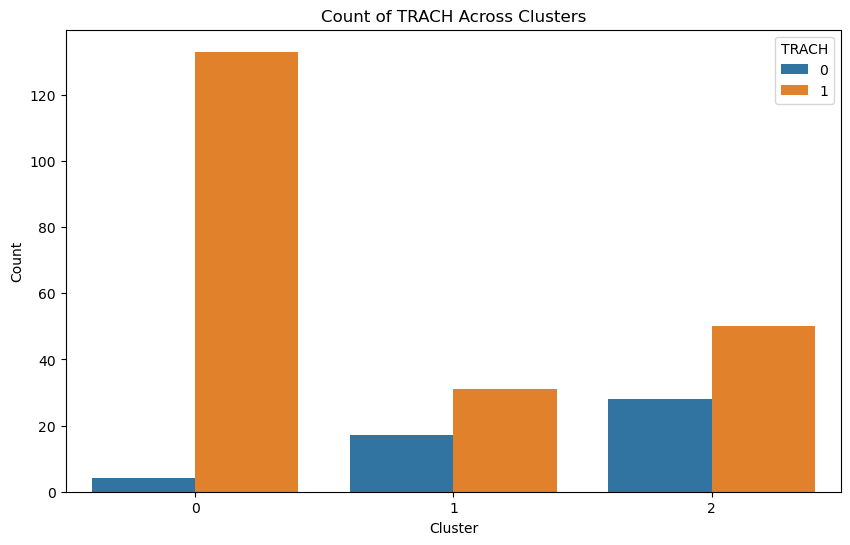

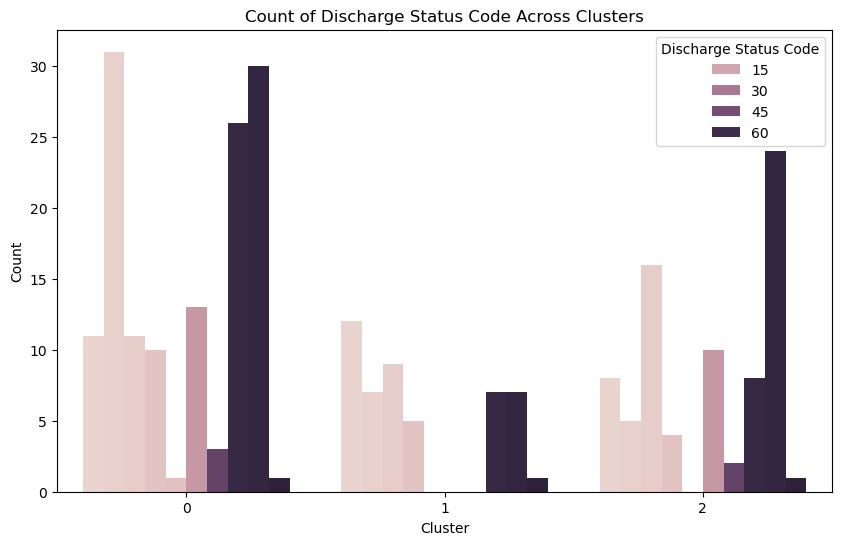

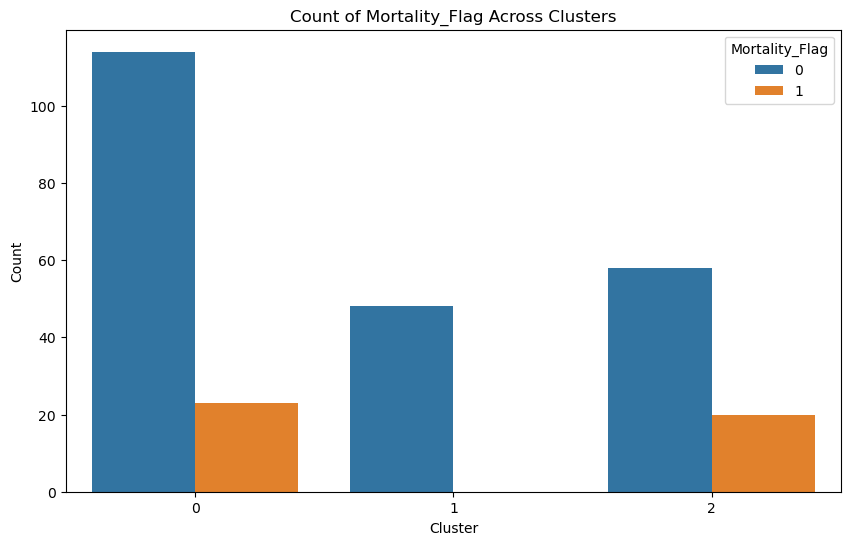

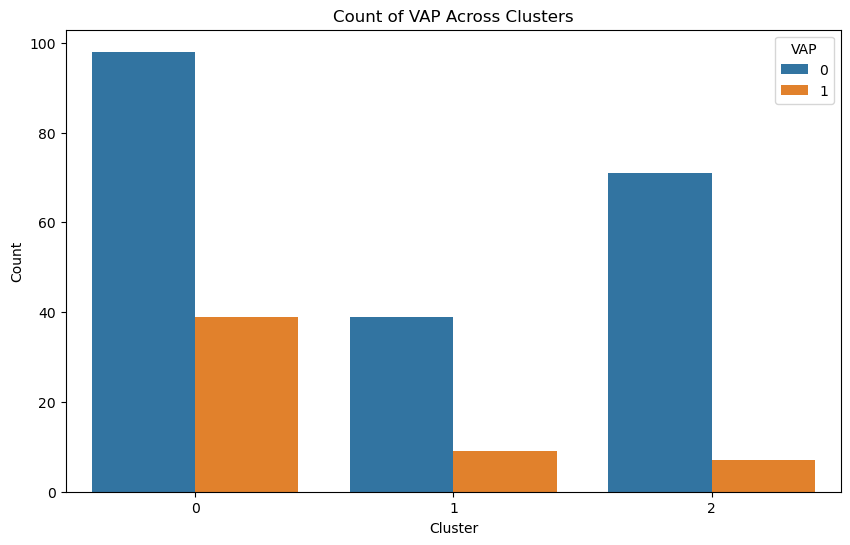

ANOVA Test Results:
Age: F-statistic = 83.28709189648866, p-value = 1.1149139130170345e-28
BMI: F-statistic = 4.017186365551162, p-value = 0.019132483054619478
GCS: F-statistic = 110.26482299403668, p-value = 2.1033473966853848e-35
ISS: F-statistic = 40.22633644511351, p-value = 6.013924536798378e-16
ICU LOS Days: F-statistic = 14.11542501997651, p-value = 1.514520321939706e-06
Hospital LOS Days: F-statistic = 10.819216672838683, p-value = 3.0660953651759864e-05
NLR: F-statistic = 28.62189849535926, p-value = 5.826760186623112e-12
Chi-square Test Results:
Gender: Chi-square = 1.9630300614719527, p-value = 0.3747429215128313
PEG: Chi-square = 1.69420968241586, p-value = 0.42865415906086046
TRACH: Chi-square = 46.567545339054256, p-value = 7.726556980951433e-11
Discharge Status Code: Chi-square = 39.378608698972705, p-value = 0.0025340724945525058
Mortality_Flag: Chi-square = 14.324422779167302, p-value = 0.0007753380814660409
VAP: Chi-square = 11.584560574853512, p-value = 0.00305101704

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, chi2_contingency
import pandas as pd

# Categorizing the specialty services into ACS&TRAUMA/Non-Trauma Surgery/NA
def categorize_service(service):
    if pd.isna(service):
        return 'NA'
    elif service == 'ACS & TRAUMA':
        return 'ACS & TRAUMA'
    else:
        return 'Other'

df['PEG_SERVICE_CATEGORY'] = df['PEG SERVICE'].apply(categorize_service)
df['TRACH_SERVICE_CATEGORY'] = df['TRACH SERVICE'].apply(categorize_service)
print(df[['PEG_SERVICE_CATEGORY', 'TRACH_SERVICE_CATEGORY']].head())

#  features to evaluate
features_to_evaluate = ['Age', 'BMI', 'GCS', 'ISS', 'ICU LOS Days', 
                        'Hospital LOS Days', 'NLR', 'Gender', 'PEG', 
                        'TRACH', 'Discharge Status Code', 'Mortality_Flag', 
                        'VAP']

#  summary statistics for each cluster
summary_stats = df.groupby('Cluster_Labels_Agglomerative')[features_to_evaluate].describe()
print("Summary Statistics for Each Cluster:")
print(summary_stats)

for feature in ['Age', 'BMI', 'GCS', 'ISS', 'ICU LOS Days', 'Hospital LOS Days', 'NLR']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster_Labels_Agglomerative', y=feature, data=df)
    plt.title(f'Distribution of {feature} Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

for feature in ['Gender', 'PEG', 'TRACH', 'Discharge Status Code', 'Mortality_Flag', 'VAP']:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Cluster_Labels_Agglomerative', hue=feature, data=df)
    plt.title(f'Count of {feature} Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.show()

#  ANOVA test for continuous variables
anova_results = {}
for feature in ['Age', 'BMI', 'GCS', 'ISS', 'ICU LOS Days', 'Hospital LOS Days', 'NLR']:
    groups = [df[df['Cluster_Labels_Agglomerative'] == i][feature] for i in df['Cluster_Labels_Agglomerative'].unique()]
    F, p = f_oneway(*groups)
    anova_results[feature] = (F, p)

print("ANOVA Test Results:")
for feature, (F, p) in anova_results.items():
    print(f"{feature}: F-statistic = {F}, p-value = {p}")

#  chi-square test for categorical variables
chi_square_results = {}
for feature in ['Gender', 'PEG', 'TRACH', 'Discharge Status Code', 'Mortality_Flag', 'VAP']:
    contingency_table = pd.crosstab(df[feature], df['Cluster_Labels_Agglomerative'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[feature] = (chi2, p)

print("Chi-square Test Results:")
for feature, (chi2, p) in chi_square_results.items():
    print(f"{feature}: Chi-square = {chi2}, p-value = {p}")


In [44]:
import pandas as pd
from scipy.stats import f_oneway, chi2_contingency

# Calculating the summary statistics for each cluster
summary_table = pd.DataFrame()

# Continuous variables: mean, standard deviation, and ANOVA p-values for Age, BMI, NLR, LOS
continuous_features = ['Age', 'BMI', 'NLR', 'ICU LOS Days', 'Hospital LOS Days']
anova_results = {}
for feature in continuous_features:
    summary_table[f'{feature}_Mean'] = df.groupby('Cluster_Labels_Agglomerative')[feature].mean()
    summary_table[f'{feature}_SD'] = df.groupby('Cluster_Labels_Agglomerative')[feature].std()  # Add SD for all continuous features
    
    # ANOVA test
    groups = [df[df['Cluster_Labels_Agglomerative'] == i][feature] for i in df['Cluster_Labels_Agglomerative'].unique()]
    F, p = f_oneway(*groups)
    anova_results[feature] = p
    summary_table[f'{feature}_p_value'] = p

# Gender: Percentage of Males and Females in each cluster
summary_table['Gender_Male%'] = df[df['Gender'] == 'M'].groupby('Cluster_Labels_Agglomerative')['Gender'].count() / df.groupby('Cluster_Labels_Agglomerative')['Gender'].count() * 100
summary_table['Gender_Female%'] = df[df['Gender'] == 'F'].groupby('Cluster_Labels_Agglomerative')['Gender'].count() / df.groupby('Cluster_Labels_Agglomerative')['Gender'].count() * 100

# Categorical variables: percentage and chi-square p-values for TRACH, PEG, VAP
categorical_features = ['TRACH', 'PEG', 'VAP']
chi_square_results = {}
for feature in categorical_features:
    summary_table[f'{feature}%'] = df[df[feature] == 1].groupby('Cluster_Labels_Agglomerative')[feature].count() / df.groupby('Cluster_Labels_Agglomerative')[feature].count() * 100
    
    # Chi-square test
    contingency_table = pd.crosstab(df[feature], df['Cluster_Labels_Agglomerative'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[feature] = p
    summary_table[f'{feature}_p_value'] = p

# Most common discharge status code: Top 3 with their percentages
def get_top_3_modes(cluster_data):
    mode_series = cluster_data.value_counts().nlargest(3)
    mode_percentages = (mode_series / cluster_data.size) * 100
    return ', '.join([f"{code} ({percent:.1f}%)" for code, percent in zip(mode_series.index, mode_percentages)])

summary_table['Top_3_Discharge_Status_Codes'] = df.groupby('Cluster_Labels_Agglomerative')['Discharge Status Code'].agg(lambda x: get_top_3_modes(x))

# Display the summary table
print("Summary Table for Each Cluster (0, 1, 2):")
print(summary_table)


Summary Table for Each Cluster (0, 1, 2):
                               Age_Mean     Age_SD   Age_p_value   BMI_Mean  \
Cluster_Labels_Agglomerative                                                  
0                             34.175182  13.588435  1.114914e-28  25.931708   
1                             42.937500  18.660923  1.114914e-28  21.931813   
2                             61.692308  15.012815  1.114914e-28  25.566846   

                                BMI_SD  BMI_p_value  NLR_Mean    NLR_SD  \
Cluster_Labels_Agglomerative                                              
0                             9.460108     0.019132  3.280630  3.078078   
1                             8.119863     0.019132  8.891593  6.155588   
2                             7.151404     0.019132  5.544544  5.316213   

                               NLR_p_value  ICU LOS Days_Mean  ...  \
Cluster_Labels_Agglomerative                                   ...   
0                             5.826760e-12    

#### Analysis of Service across clusters

PEG_SERVICE_CATEGORY (Excluding NAs): Chi-square = 13.646552830188678, p-value = 0.0010881498447317338
TRACH_SERVICE_CATEGORY (Excluding NAs): Chi-square = 2.842822782763359, p-value = 0.2413731044537912


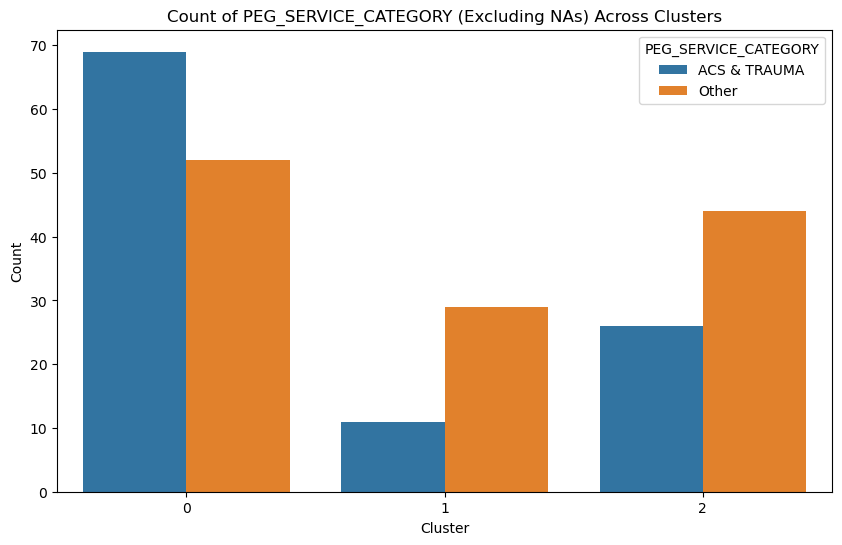

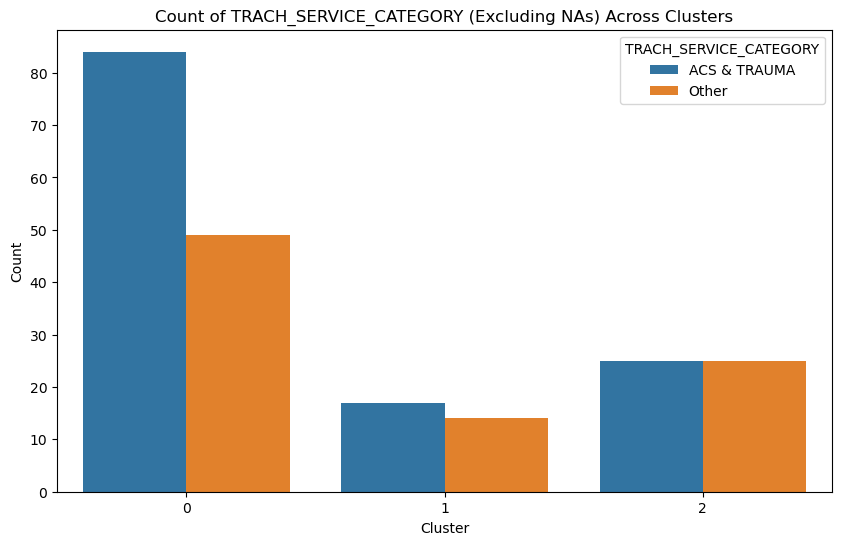

In [45]:
df_filtered_peg = df[df['PEG_SERVICE_CATEGORY'] != 'NA']
df_filtered_trach = df[df['TRACH_SERVICE_CATEGORY'] != 'NA']

#  chi-square test for PEG_SERVICE_CATEGORY excluding NAs
contingency_table_peg = pd.crosstab(df_filtered_peg['PEG_SERVICE_CATEGORY'], df_filtered_peg['Cluster_Labels_Agglomerative'])
chi2_peg, p_peg, dof_peg, expected_peg = chi2_contingency(contingency_table_peg)
print(f"PEG_SERVICE_CATEGORY (Excluding NAs): Chi-square = {chi2_peg}, p-value = {p_peg}")

#  chi-square test for TRACH_SERVICE_CATEGORY excluding NAs
contingency_table_trach = pd.crosstab(df_filtered_trach['TRACH_SERVICE_CATEGORY'], df_filtered_trach['Cluster_Labels_Agglomerative'])
chi2_trach, p_trach, dof_trach, expected_trach = chi2_contingency(contingency_table_trach)
print(f"TRACH_SERVICE_CATEGORY (Excluding NAs): Chi-square = {chi2_trach}, p-value = {p_trach}")

# Visualize 
for feature in ['PEG_SERVICE_CATEGORY', 'TRACH_SERVICE_CATEGORY']:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Cluster_Labels_Agglomerative', hue=feature, data=df[df[feature] != 'NA'])
    plt.title(f'Count of {feature} (Excluding NAs) Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.show()


In [46]:
import pandas as pd
import scipy.stats as stats
import numpy as np

# proportion of ACS/Trauma involvement for PEG and TRACH in each cluster
def calculate_proportions(df, service_col, cluster_col):
    proportions = df.groupby(cluster_col)[service_col].apply(lambda x: (x == 'ACS & TRAUMA').mean())
    return proportions

# Proportion of ACS/Trauma for PEG
peg_proportions = calculate_proportions(df, 'PEG_SERVICE_CATEGORY', 'Cluster_Labels_Agglomerative')

# Proportion of ACS/Trauma for TRACH
trach_proportions = calculate_proportions(df, 'TRACH_SERVICE_CATEGORY', 'Cluster_Labels_Agglomerative')

print("Proportions of ACS/Trauma involvement in PEG across clusters:")
print(peg_proportions)

print("\nProportions of ACS/Trauma involvement in TRACH across clusters:")
print(trach_proportions)

# Z-test for two proportions as an example
def z_test_proportions(p1, n1, p2, n2):
    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    z = (p1 - p2) / np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p_value

z_peg, p_peg = z_test_proportions(peg_proportions[0], df[df['Cluster_Labels_Agglomerative'] == 0].shape[0],
                                  peg_proportions[1], df[df['Cluster_Labels_Agglomerative'] == 1].shape[0])
z_trach, p_trach = z_test_proportions(trach_proportions[0], df[df['Cluster_Labels_Agglomerative'] == 0].shape[0],
                                      trach_proportions[1], df[df['Cluster_Labels_Agglomerative'] == 1].shape[0])

print(f"\nZ-test for PEG between Cluster 0 and Cluster 1: Z = {z_peg}, p-value = {p_peg}")
print(f"Z-test for TRACH between Cluster 0 and Cluster 1: Z = {z_trach}, p-value = {p_trach}")


Proportions of ACS/Trauma involvement in PEG across clusters:
Cluster_Labels_Agglomerative
0    0.503650
1    0.229167
2    0.333333
Name: PEG_SERVICE_CATEGORY, dtype: float64

Proportions of ACS/Trauma involvement in TRACH across clusters:
Cluster_Labels_Agglomerative
0    0.613139
1    0.354167
2    0.320513
Name: TRACH_SERVICE_CATEGORY, dtype: float64

Z-test for PEG between Cluster 0 and Cluster 1: Z = 3.303258225797232, p-value = 0.0009556833982684587
Z-test for TRACH between Cluster 0 and Cluster 1: Z = 3.1011250561554755, p-value = 0.0019278685217580804


#### Visualization of Clusters across Domains

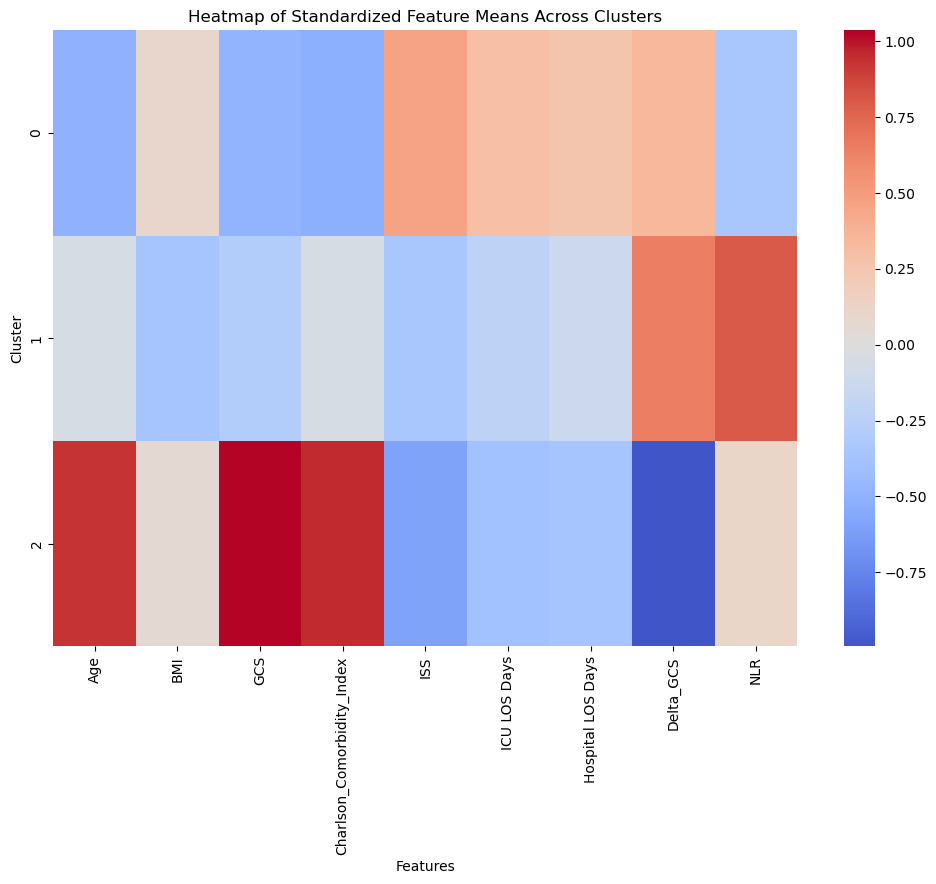

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

features_to_evaluate = ['Age', 'BMI', 'GCS','Charlson_Comorbidity_Index', 'ISS', 'ICU LOS Days', 
                        'Hospital LOS Days', 'Delta_GCS', 'NLR']

# Standardize 
scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[features_to_evaluate] = scaler.fit_transform(df[features_to_evaluate])

cluster_means = df_standardized.groupby('Cluster_Labels_Agglomerative')[features_to_evaluate].mean()

# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, annot=False, cmap='coolwarm', center=0)
plt.title('Heatmap of Standardized Feature Means Across Clusters')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.show()


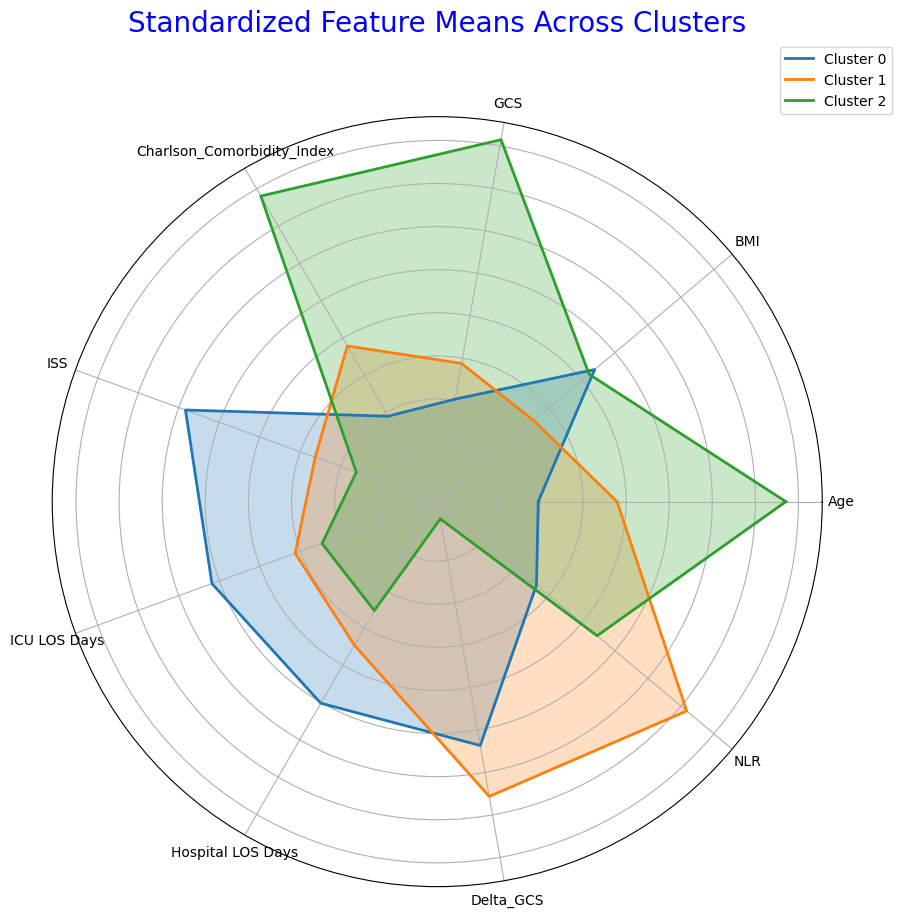

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Mean of each feature per cluster
cluster_means = df_standardized.groupby('Cluster_Labels_Agglomerative')[features_to_evaluate].mean()

# Radar Chart
labels = features_to_evaluate
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, row in cluster_means.iterrows():
    values = row.tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=2, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

ax.set_yticklabels([])

plt.title('Standardized Feature Means Across Clusters', size=20, color='blue', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()


In [49]:
df.columns

Index(['ID', 'Age', 'Gender', 'Race', 'BMI', 'Date of Admission',
       'Date of Hospital Discharge', 'PEG', 'TRACH', 'PEG TIME', 'TRACH TIME',
       'PEG SERVICE', 'TRACH SERVICE', 'Discharge Disposition',
       'Discharge Status Code', 'GCS', 'GCS Qualifier', 'ISS',
       '#CO-MORBIDITIES', 'ICU LOS Days', 'Hospital LOS Days',
       '#Of total complications', 'Date of Death', 'Date of readmission',
       'Comorbidities List', 'Charlson_Comorbidity_Index', 'DischargeGCS',
       'VAP', 'Total_Neutrophils', 'Total_Lymphocytes', 'NLR',
       'PEG_Days_Difference', 'TRACH_Days_Difference',
       'Decannulation_Days_Difference', 'Oral_Intake_Days_Difference',
       'PEG_ORDER_to_ADMISSION', 'Trach_ORDER_to_ADMISSION', 'Delta_GCS',
       'Readmission_Flag', 'Mortality_Flag', 'Cluster_Labels_Agglomerative',
       'PEG_SERVICE_CATEGORY', 'TRACH_SERVICE_CATEGORY'],
      dtype='object')

#### Survival Analysis

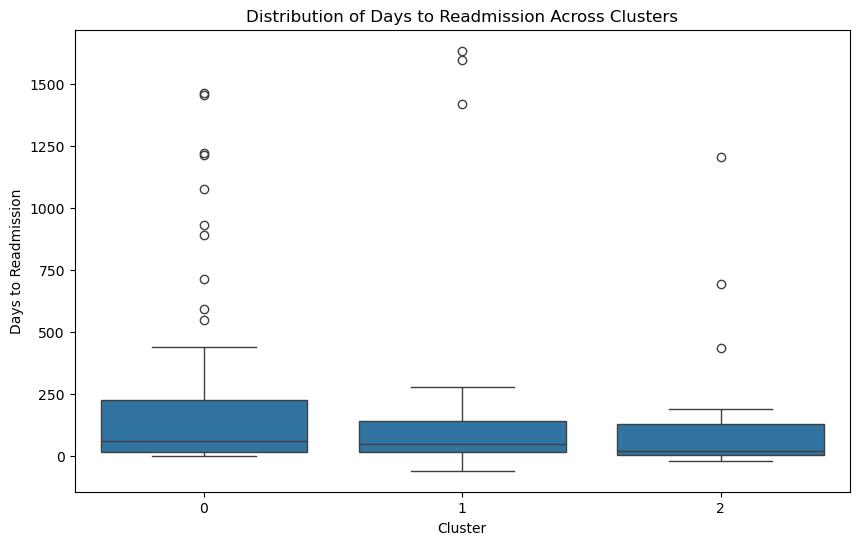

In [50]:
# Calculate days to readmission
df['Days_to_Readmission'] = (df['Date of readmission'] - df['Date of Hospital Discharge']).dt.days
df['Days_to_Readmission'] = df['Days_to_Readmission'].fillna(float('inf'))  # Mark as infinity for patients not readmitted

# Visualize Readmission
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster_Labels_Agglomerative', y='Days_to_Readmission', data=df)
plt.title('Distribution of Days to Readmission Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Days to Readmission')
plt.show()


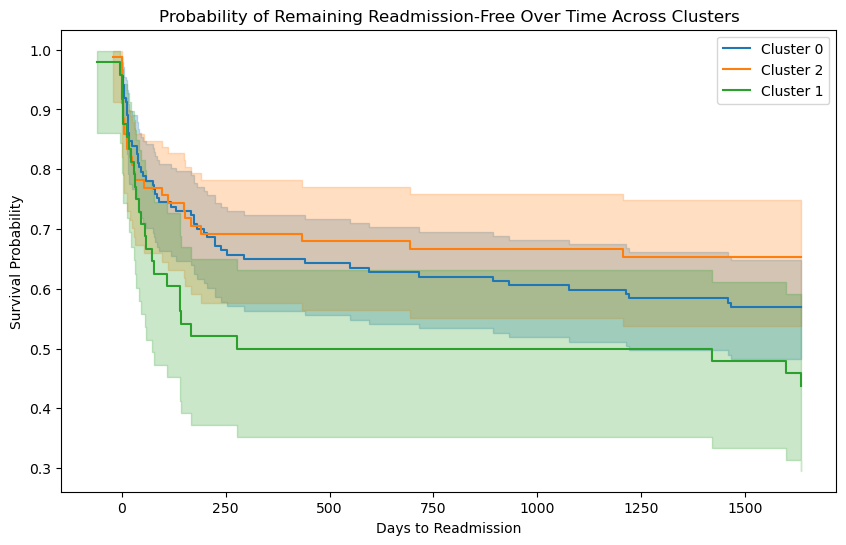

In [51]:
from lifelines import KaplanMeierFitter
import numpy as np

max_follow_up = df['Days_to_Readmission'][df['Days_to_Readmission'] != float('inf')].max()
df['Days_to_Readmission'] = df['Days_to_Readmission'].replace(float('inf'), max_follow_up)

kmf = KaplanMeierFitter()

# For each cluster, plot the survival curve
plt.figure(figsize=(10, 6))
for i in df['Cluster_Labels_Agglomerative'].unique():
    kmf.fit(durations=df[df['Cluster_Labels_Agglomerative'] == i]['Days_to_Readmission'],
            event_observed=df[df['Cluster_Labels_Agglomerative'] == i]['Readmission_Flag'])
    kmf.plot(label=f'Cluster {i}')

plt.title('Probability of Remaining Readmission-Free Over Time Across Clusters')
plt.xlabel('Days to Readmission')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()


In [52]:
from lifelines.statistics import logrank_test

#  log-rank test between each pair of clusters
for i in range(optimal_clusters):
    for j in range(i + 1, optimal_clusters):
        group_i = df[df['Cluster_Labels_Agglomerative'] == i]
        group_j = df[df['Cluster_Labels_Agglomerative'] == j]
        
        result = logrank_test(
            group_i['Days_to_Readmission'], group_j['Days_to_Readmission'],
            event_observed_A=group_i['Readmission_Flag'], event_observed_B=group_j['Readmission_Flag']
        )
        
        print(f"Log-rank test between Cluster {i} and Cluster {j}: p-value = {result.p_value:.4f}")


Log-rank test between Cluster 0 and Cluster 1: p-value = 0.0809
Log-rank test between Cluster 0 and Cluster 2: p-value = 0.3584
Log-rank test between Cluster 1 and Cluster 2: p-value = 0.0262


In [53]:
df['Cluster'] = cluster_labels_Agglomerative

#  the readmission rate per cluster
readmission_rate_per_cluster = df.groupby('Cluster')['Readmission_Flag'].mean()

print(readmission_rate_per_cluster)


Cluster
0    0.430657
1    0.562500
2    0.346154
Name: Readmission_Flag, dtype: float64


In [54]:
from scipy.stats import chi2_contingency

# Create a contingency table for clusters and readmission
contingency_table = pd.crosstab(df['Cluster'], df['Readmission_Flag'])

# Chi-Square test
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-Square Test P-Value: {p}")


Chi-Square Test P-Value: 0.05852266969032254


In [55]:
df.columns

Index(['ID', 'Age', 'Gender', 'Race', 'BMI', 'Date of Admission',
       'Date of Hospital Discharge', 'PEG', 'TRACH', 'PEG TIME', 'TRACH TIME',
       'PEG SERVICE', 'TRACH SERVICE', 'Discharge Disposition',
       'Discharge Status Code', 'GCS', 'GCS Qualifier', 'ISS',
       '#CO-MORBIDITIES', 'ICU LOS Days', 'Hospital LOS Days',
       '#Of total complications', 'Date of Death', 'Date of readmission',
       'Comorbidities List', 'Charlson_Comorbidity_Index', 'DischargeGCS',
       'VAP', 'Total_Neutrophils', 'Total_Lymphocytes', 'NLR',
       'PEG_Days_Difference', 'TRACH_Days_Difference',
       'Decannulation_Days_Difference', 'Oral_Intake_Days_Difference',
       'PEG_ORDER_to_ADMISSION', 'Trach_ORDER_to_ADMISSION', 'Delta_GCS',
       'Readmission_Flag', 'Mortality_Flag', 'Cluster_Labels_Agglomerative',
       'PEG_SERVICE_CATEGORY', 'TRACH_SERVICE_CATEGORY', 'Days_to_Readmission',
       'Cluster'],
      dtype='object')